In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt	
import numpy as np
import os
import csv
import sklearn
from sklearn.model_selection import train_test_split
import cv2
from scipy import ndimage # for importing image as RGB
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.layers import Cropping2D, GaussianNoise, MaxPool2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers

Using TensorFlow backend.


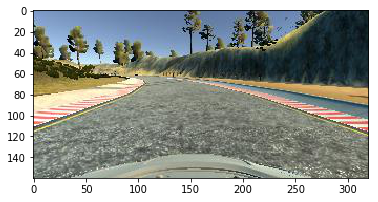

In [4]:
######################
### Initialization ###
######################

path = '../data/'
example_img = plt.imread(path+'IMG/center_2019_09_14_10_46_34_907.jpg')

# plot example
plt.imshow(example_img)
plt.show()
    
img_shape = example_img.shape

save_path = './model.h5'

In [5]:
#############################
### Parameter definitions ###
#############################

# set crop values
top_crop = 60
bottom_crop = 0
left_crop = 0
right_crop = 0

test_size = .2
angle_offset = .25
batch_size = 32
num_epochs = 5

# L2-Regularization
l2_penal = .0001
# Dropout rates
dr1 = 0.3
dr2 = 0.2
dr3 = 0.1

In [6]:
import pandas as pd

columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

df = pd.read_csv(path+'driving_log.csv', usecols=[0,1,2,3], names=columns)
print('Data frame columns of interest: ', list(df.columns))

# drop all columns which are not needed
# df = df.drop(columns=['throttle', 'brake', 'speed'])
# print('Data' frame columns of interest: ', list(df.columns))

Data frame columns of interest:  ['center', 'left', 'right', 'steering']


In [7]:
import random

df_cp = df.copy()
print('Size of original df set: ', len(df_cp))

# # remove some images with angle=0
# no_steering_inds = df_cp[df_cp.steering==0]
# print(len(no_steering_inds))
# no_steering_inds_p5 = int(len(no_steering_inds)/2)
# print(no_steering_inds_p5)

# drop_inds = df_cp[df_cp.steering == 0].sample(n=no_steering_inds_p5).index

# df_cp = df_cp.drop(drop_inds)
# print('Cutted length: ', len(df_cp))


Size of original df set:  5283


(array([  22.,    4.,   49.,   69.,  251.,  482.,  976., 2318.,  656.,
         256.,  124.,   45.,    7.,    4.,   20.]),
 array([-0.6235294 , -0.54156862, -0.45960784, -0.37764706, -0.29568628,
        -0.2137255 , -0.13176472, -0.04980394,  0.03215684,  0.11411762,
         0.1960784 ,  0.27803918,  0.35999996,  0.44196074,  0.52392152,
         0.6058823 ]),
 <a list of 15 Patch objects>)

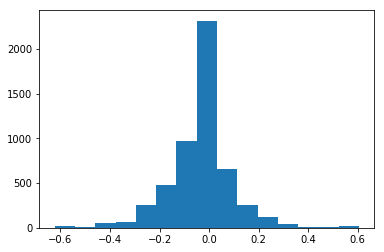

In [8]:
n_bins = 15

plt.hist(df.steering, bins=n_bins)

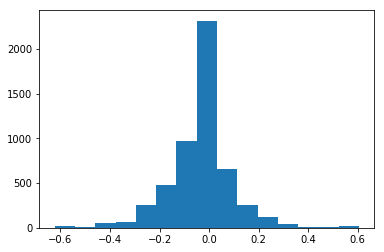

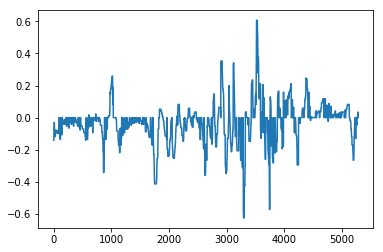

2318


In [9]:
bin_min_lim = df_cp.steering.min()
bin_max_lim = df_cp.steering.max()

bin_width = (1-(-1))/n_bins
# min_val + num_bins*bin_width

df_cp.steering.value_counts(bins=n_bins)

(counts, bins, _patches) = plt.hist(df_cp.steering, bins=n_bins)
plt.show()
plt.plot(df_cp.steering)
plt.show()
counts = counts.astype(int)

max_count = max(counts)
print(max_count)
curr_bin_min_lim = bin_min_lim

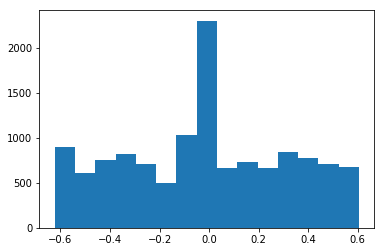

Size of augmented df set:  12797


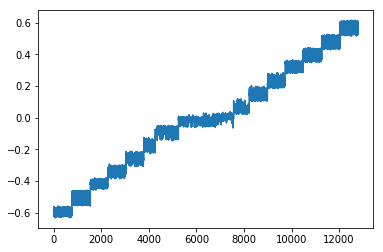

In [10]:
df_aug = pd.DataFrame(columns=list(df.columns))

for curr_bin in range(n_bins):
    
    ind = (df_cp.steering > bins[curr_bin]) & (df_cp.steering <= bins[curr_bin+1])
    elem_per_bin = sum(ind)
    
    if elem_per_bin>0:
        aug_fact = int(max_count / elem_per_bin)
        df_aug = df_aug.append([df_cp[ind]]*max(int(aug_fact/3),1), ignore_index=True)
        

# add noise for not using the identical angles for augmented images
df_aug.steering += np.random.normal(-0.005,0.005,len(df_aug.steering))
    
(counts_aug, bins_aug, _patches_aug) = plt.hist(df_aug.steering, bins=bins)
plt.show()
counts_aug = counts_aug.astype(int)


# %matplotlib inline
plt.plot(df_aug.steering)
print('Size of augmented df set: ', len(df_aug))

In [9]:
# Model is based on NVIDIAS paper "End to End Learning for Self-Driving Cars"
def def_model():

    model = Sequential()
    # normalize df 
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(img_shape[0], img_shape[1], img_shape[2]), 
        output_shape=(img_shape[0], img_shape[1], img_shape[2])))
    # crop image
#     model.add(Cropping2D(cropping=((top_crop, bottom_crop),(left_crop, right_crop))))
    # downscale image
    model.add(MaxPool2D((2,2)))
    # add noise layer
    model.add(GaussianNoise(.25))
    # add convolutional layers
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), activation='relu'))#, subsample=(2, 2)))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), activation='relu'))#, subsample=(2, 2)))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), activation='relu'))#, subsample=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), activation='relu'))
    # add flatten layer
    model.add(Flatten())
    # add fully connected layers plus dropout
    model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(l2_penal)))
    model.add(Dropout(rate=dr1))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(l2_penal)))
    model.add(Dropout(rate=dr2))
    model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(l2_penal)))
    model.add(Dropout(rate=dr3))
    model.add(Dense(1))

    # show model summary
    model.summary()

    # compile method configures learning process
    model.compile(optimizer='adam', loss='mse')

    return model

In [10]:
model = def_model()

W0915 18:39:12.037986 139710673282880 deprecation_wrapper.py:119] From /home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0915 18:39:12.056075 139710673282880 deprecation_wrapper.py:119] From /home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 18:39:12.073513 139710673282880 deprecation_wrapper.py:119] From /home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0915 18:39:12.079246 139710673282880 deprecation_wrapper.py:119] From /home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 80, 160, 3)        0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 80, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 78, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 37, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 17, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 15, 64)        

In [11]:
# Generator is defined to avoid loading all df into memory at once
def generator(df_split, batch_size=32):
    num_samples = len(df_split)
    while 1:
        df_split = sklearn.utils.shuffle(df_split)
        for offset in range(0, num_samples, batch_size):
            batch_samples = df_split.iloc[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples.iterrows():
                
                # center camera image
                center_img_name = path+batch_sample[1].center
                center_img = plt.imread(center_img_name)
                center_angle = float(batch_sample[1].steering)
                images.append(center_img)
                angles.append(center_angle)
                # include flipped image
                images.append(np.fliplr(center_img))
                angles.append(-center_angle)
                
                # left camera images
                left_img_name = path+batch_sample[1].left
                left_img = plt.imread(left_img_name)
                left_angle = center_angle + angle_offset
                images.append(left_img)
                angles.append(left_angle)
                # include flipped image
                images.append(np.fliplr(left_img))
                angles.append(-left_angle)
                
                # right camera images
                right_img_name = path+batch_sample[1].right
                right_img = plt.imread(right_img_name)
                right_angle = center_angle - angle_offset
                images.append(right_img)
                angles.append(right_angle)
                # include flipped image
                images.append(np.fliplr(right_img))
                angles.append(-right_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [12]:
# prepare df by splitting into training and validation samples and creating generators
def prepare_df(df):

    train_samples, validation_samples = train_test_split(df, test_size=0.2)

    train_generator = generator(train_samples, batch_size=batch_size)
    validation_generator = generator(validation_samples, batch_size=batch_size)

    return len(train_samples), len(validation_samples), train_generator, validation_generator

In [13]:
num_train_samples, num_validation_samples, train_generator, validation_generator = prepare_df(df_aug)
# num_train_samples, num_validation_samples, train_generator, validation_generator = prepare_df(df_cp)

In [14]:
# check if gpu is available for training
def check_gpu_status():

    print('\n\nIs GPU available: ', tf.test.is_gpu_available())
    if not tf.test.is_gpu_available:
        raise Exception('GPU not available')
    print('GPU device name: ', tf.test.gpu_device_name())
    print('Is built with cuda: ', tf.test.is_built_with_cuda())
    print('\n')

In [15]:
check_gpu_status()



Is GPU available:  True
GPU device name:  /device:GPU:0
Is built with cuda:  True




In [16]:
# train and validate the model
def train_model(model, num_train_samples, num_validation_samples, train_generator, validation_generator):

    # create callbacks
    checkpoint = ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True)
    stopper = EarlyStopping(monitor='val_loss', min_delta=0.0003, patience=3)

    # fit model
    history = model.fit_generator(train_generator, 
                        steps_per_epoch=np.ceil(num_train_samples*6/batch_size), # the factor 6 is there because the generator outputs all 3 camera images plus flipped version
                        validation_df=validation_generator, 
                        validation_steps=np.ceil(num_validation_samples*6/batch_size), 
                        callbacks=[checkpoint, stopper],
                        epochs=num_epochs,
                        verbose=1)

    print(history.history.keys())
    ### plot the training and validation loss for each epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

In [17]:
train_model(model, num_train_samples, num_validation_samples, train_generator, validation_generator)

Epoch 1/5
1920/1920 [==============================] - 890s 463ms/step - loss: 0.0158 - val_loss: 0.0051
Epoch 2/5
1001/1920 [==============>...............] - ETA: 5:10 - loss: 0.0079

KeyboardInterrupt: 

In [ ]:
# # Generator is defined to avoid loading all df into memory at once
# def generator(samples, batch_size=32):
#     num_samples = len(samples)
#     while 1:
#         samples = sklearn.utils.shuffle(samples)
#         for offset in range(0, num_samples, batch_size):
#             batch_samples = samples[offset:offset+batch_size]

#             images = []
#             angles = []
#             for batch_sample in batch_samples:
                
#                 # center camera image
#                 center_img_name = path+'IMG/'+batch_sample[0].split('/')[-1]
#                 center_img = plt.imread(center_img_name)
#                 center_angle = float(batch_sample[3])
#                 images.append(center_img)
#                 angles.append(center_angle)
#                 # include flipped image
#                 images.append(np.fliplr(center_img))
#                 angles.append(-center_angle)
                
#                 # left camera images
#                 left_img_name = path+'IMG/'+batch_sample[1].split('/')[-1]
#                 left_img = plt.imread(left_img_name)
#                 left_angle = center_angle + angle_offset
#                 images.append(left_img)
#                 angles.append(left_angle)
#                 # include flipped image
#                 images.append(np.fliplr(left_img))
#                 angles.append(-left_angle)
                
#                 # right camera images
#                 right_img_name = path+'IMG/'+batch_sample[2].split('/')[-1]
#                 right_img = plt.imread(right_img_name)
#                 right_angle = center_angle - angle_offset
#                 images.append(right_img)
#                 angles.append(right_angle)
#                 # include flipped image
#                 images.append(np.fliplr(right_img))
#                 angles.append(-right_angle)

#             X_train = np.array(images)
#             y_train = np.array(angles)
#             yield sklearn.utils.shuffle(X_train, y_train)

In [ ]:

from model import *

In [ ]:
print('Import df from: {}'.format(path))

In [ ]:
print('Original image shape =',img_shape)
print('Crop image at row #', top_crop)

plt.imshow(example_img)

x_val = np.arange(0,example_img.shape[1])
plt.plot(x_val, np.ones(len(x_val))*top_crop, 'r');

## Load images

In [ ]:
samples, _angles_orig, _angles_aug = read_csv();

## Exploration: Display angle distribution and angle over time

In [ ]:
def explore_df(_angles_orig, _angles_aug):
    
    fig = plt.figure(figsize=(10,6))
    plt.hist(_angles_orig, 30)
    plt.title('Original df: steering angle distribution (absolute)')
    plt.xlabel('Steering angle')
    plt.show()

    fig = plt.figure(figsize=(10,6))
    plt.plot(_angles_orig)
    plt.title('Original df: Angle over time')
    plt.xlabel('Sample')
    plt.ylabel('Angle')
    plt.show()
    
    fig = plt.figure(figsize=(10,6))
    # sns.distplot(angles, kde=False)
    plt.hist(_angles_aug, 30)
    plt.title('Augmented df: steering angle distribution (absolute)')
    plt.xlabel('Steering angle')
    plt.show()

    fig = plt.figure(figsize=(10,6))
    plt.plot(_angles_aug)
    plt.title('Augmented df: Angle over time')
    plt.xlabel('Sample')
    plt.ylabel('Angle')
    plt.show()

In [ ]:
explore_df(_angles_orig, _angles_aug)

In [ ]:
# display example images and angles:
for i in range(3):
    rand_num = np.random.randint(len(samples))
    rand_sample = samples[rand_num]
    center_img_name = path+'IMG/'+rand_sample[0].split('/')[-1]
    center_img = plt.imread(center_img_name)
    center_angle = float(rand_sample[3])
    print(center_angle)
#     plt.title('Center angle: ', center_angle)
    plt.imshow(center_img); plt.show()

In [ ]:
# # create list with all image names and angles
# def read_csv():
# 	samples = []
# 	_angles_orig = []
# 	_angles_aug = []
# 	with open(path+'driving_log.csv') as csvfile:
# 	    reader = csv.reader(csvfile)
# 	    next(reader) # skip headers in first row
# 	    for line in reader:
# 	        # samples.append(line)
# 	        samples.append(line)
# 	        # append sample again for all angles != 0 (balancing) # Noise layer in the model avoids using the identical images.
# 	        _angle = float(line[3])
# 	        _angles_orig.append(_angle)
# 	        _angles_aug.append(_angle)
# 	        # if _angle!=0:
#         	num_copies = abs(int(np.round(_angle*10)))
#         	# print(num_copies)
#         	for i in range(num_copies):
# 	        	samples.append(line)
# 	        	_angles_aug.append(_angle)
# 	print('number of images (augmented df set): ',len(samples))
# 	return samples, _angles_orig, _angles_aug
